2025-11-17 13:40:37.592609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763386837.790681      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763386837.841419      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Dataset shape: (73100, 15)


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


Detected -> date: Date | sku: Store ID | qty: Units Sold | category: Category
Daily aggregated shape: (18052, 4)


,sku,category,date,quantity
0,S001,Clothing,2022-01-01,1125
1,S001,Clothing,2022-01-02,740
2,S001,Clothing,2022-01-03,406
3,S001,Clothing,2022-01-04,15
4,S001,Clothing,2022-01-06,699


Using top SKU: S003 and top Category: Furniture


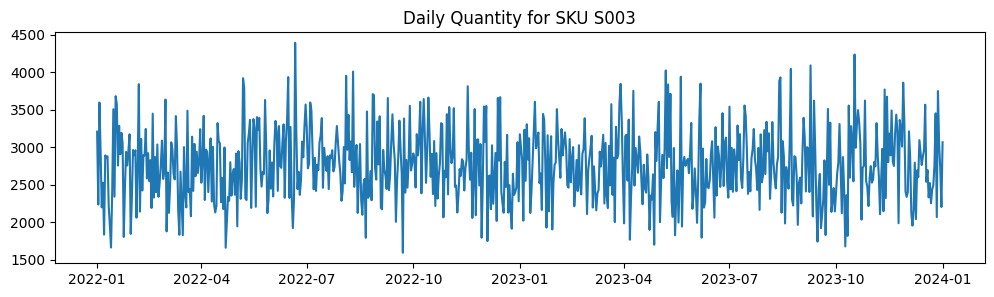

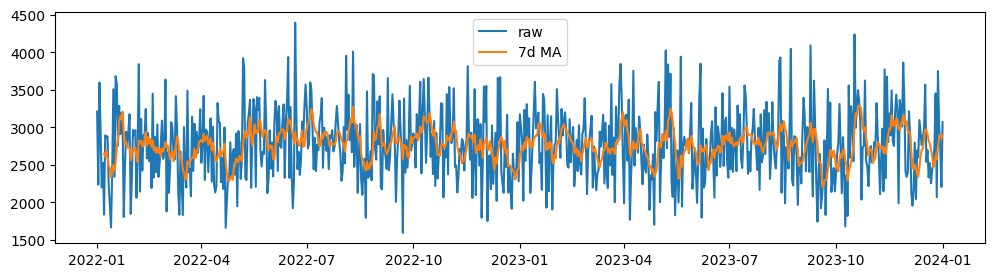

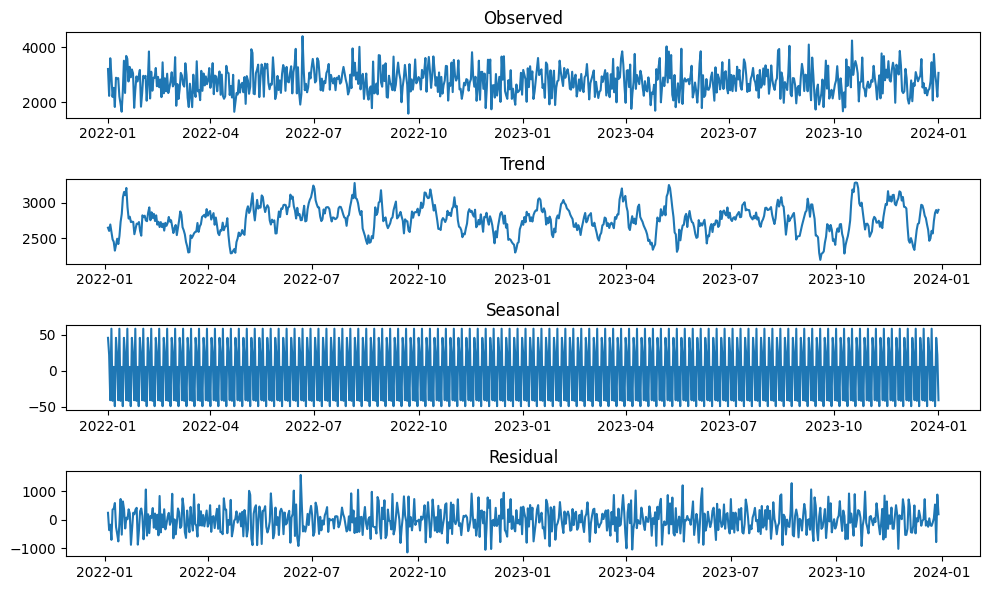

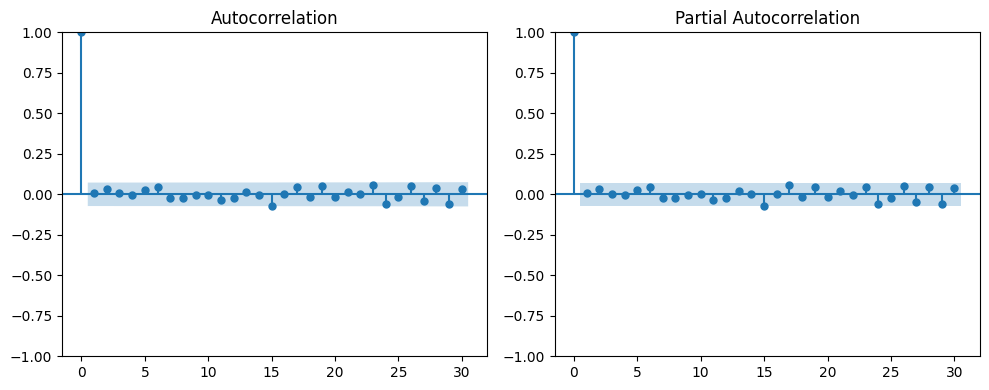

Train/test sizes: 641 90
SARIMAX RMSE: 521.450, MAPE: 14.95%


13:40:55 - cmdstanpy - INFO - Chain [1] start processing
13:40:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 512.977, MAPE: 15.03%


I0000 00:00:1763386856.404801      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1763386859.345530     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


LSTM RMSE: 516.469, MAPE: 14.95%
Model comparison:


,model,rmse,mape
1,Prophet,512.977075,15.031137
2,LSTM,516.469489,14.953975
0,SARIMAX,521.450350,14.954662


13:41:10 - cmdstanpy - INFO - Chain [1] start processing
13:41:10 - cmdstanpy - INFO - Chain [1] done processing


Chosen model for final forecasts: prophet


13:41:10 - cmdstanpy - INFO - Chain [1] start processing
13:41:10 - cmdstanpy - INFO - Chain [1] done processing


Saved forecasts to: /kaggle/working/forecasts_invenai/sku_S003_forecasts.csv /kaggle/working/forecasts_invenai/cat_Furniture_forecasts.csv
Saved evaluation summary to: /kaggle/working/forecasts_invenai/model_comparison_S003.csv


,horizon,date,forecast
0,7,2024-01-02,2778.844762
1,7,2024-01-03,2687.642510
2,7,2024-01-04,2743.028181
3,7,2024-01-05,2695.844690
4,7,2024-01-06,2799.958916


,horizon,date,forecast
0,7,2024-01-02,2660.347691
1,7,2024-01-03,2631.134509
2,7,2024-01-04,2806.389721
3,7,2024-01-05,2687.502205
4,7,2024-01-06,2757.383263


,model,rmse,mape
1,Prophet,512.977075,15.031137
2,LSTM,516.469489,14.953975
0,SARIMAX,521.450350,14.954662


All done. Check /kaggle/working/forecasts_invenai for CSV outputs.


In [1]:
# Kaggle-ready demand-forecasting notebook (SKU-level & Category-level)
# Path used: /kaggle/input/retail-store-inventory-forecasting-dataset/retail_store_inventory.csv
# It is robust: skips Prophet/LSTM if not installed and uses SARIMAX + naive fallback.

import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

# Optional models (will be used only if import succeeds)
Prophet = None
try:
    from prophet import Prophet as _Prophet
    Prophet = _Prophet
except Exception:
    print("Prophet not installed; prophet will be skipped. Install with: !pip install prophet")

TF_AVAILABLE = True
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
except Exception:
    TF_AVAILABLE = False
    print("TensorFlow/Keras not installed; LSTM will be skipped. Install with: !pip install -U tensorflow")

# Helper metrics
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.where(y_true == 0, 1e-8, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def detect_columns(df):
    date_candidates = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower() or 'day' in c.lower()]
    date_col = date_candidates[0] if date_candidates else None
    sku_candidates = [c for c in df.columns if any(k in c.lower() for k in ['sku','product','item','id'])]
    sku_col = sku_candidates[0] if sku_candidates else None
    qty_candidates = [c for c in df.columns if any(k in c.lower() for k in ['qty','quantity','sales','units','demand'])]
    qty_col = qty_candidates[0] if qty_candidates else None
    cat_candidates = [c for c in df.columns if any(k in c.lower() for k in ['category','cat','department','segment'])]
    cat_col = cat_candidates[0] if cat_candidates else None
    return date_col, sku_col, qty_col, cat_col

# --- Load dataset: change path if your dataset uses another filename ---
path = "/kaggle/input/retail-store-inventory-forecasting-dataset/retail_store_inventory.csv"
if not os.path.exists(path):
    raise FileNotFoundError(f"Dataset not found at {path}. Upload the dataset or fix the path in the cell.")

df = pd.read_csv(path)
print("Dataset shape:", df.shape)
display(df.head())

# Auto-detect columns (or set manually below if detection fails)
date_col, sku_col, qty_col, cat_col = detect_columns(df)
print("Detected -> date:", date_col, "| sku:", sku_col, "| qty:", qty_col, "| category:", cat_col)
if date_col is None or qty_col is None:
    print("Automatic detection failed. Available columns:", df.columns.tolist())
    raise ValueError("Date or quantity column not found - please set them manually in the code.")

# Normalize columns
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.dropna(subset=[date_col])
if sku_col is None:
    df['__sku'] = 'ALL_SKU'; sku_col='__sku'
if cat_col is None:
    df['__category'] = 'ALL_CAT'; cat_col='__category'
df[qty_col] = pd.to_numeric(df[qty_col], errors='coerce').fillna(0)

# Aggregate to daily
df_daily = df.groupby([sku_col, cat_col, pd.Grouper(key=date_col, freq='D')])[qty_col].sum().reset_index()
df_daily = df_daily.rename(columns={date_col:'date', qty_col:'quantity', sku_col:'sku', cat_col:'category'})
print("Daily aggregated shape:", df_daily.shape)
display(df_daily.head())

# Pick example SKU and Category (top by total quantity)
top_sku = df_daily.groupby('sku')['quantity'].sum().sort_values(ascending=False).index[0]
top_cat = df_daily.groupby('category')['quantity'].sum().sort_values(ascending=False).index[0]
print("Using top SKU:", top_sku, "and top Category:", top_cat)

def get_series(df_daily, level, value, freq='D'):
    if level=='sku':
        sel = df_daily[df_daily['sku']==value][['date','quantity']].set_index('date').sort_index()
    else:
        sel = df_daily[df_daily['category']==value][['date','quantity']].set_index('date').sort_index()
    sel = sel.resample(freq).sum().fillna(0); sel.index.name='date'
    return sel

series_sku = get_series(df_daily, 'sku', top_sku, 'D')
series_cat = get_series(df_daily, 'category', top_cat, 'D')

# --- EDA (plots) ---
plt.figure(figsize=(12,3)); plt.plot(series_sku.index, series_sku['quantity']); plt.title(f'Daily Quantity for SKU {top_sku}'); plt.show()
plt.figure(figsize=(12,3)); plt.plot(series_sku.index, series_sku['quantity'], label='raw'); plt.plot(series_sku.index, series_sku['quantity'].rolling(7).mean(), label='7d MA'); plt.legend(); plt.show()

if len(series_sku) > 14:
    try:
        dec = seasonal_decompose(series_sku['quantity'], model='additive', period=7)
        plt.figure(figsize=(10,6))
        plt.subplot(411); plt.plot(dec.observed); plt.title('Observed')
        plt.subplot(412); plt.plot(dec.trend); plt.title('Trend')
        plt.subplot(413); plt.plot(dec.seasonal); plt.title('Seasonal')
        plt.subplot(414); plt.plot(dec.resid); plt.title('Residual')
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("Decomposition error:", e)

try:
    fig = plt.figure(figsize=(10,4))
    plot_acf(series_sku['quantity'], lags=30, ax=fig.add_subplot(121))
    plot_pacf(series_sku['quantity'], lags=30, ax=fig.add_subplot(122))
    plt.tight_layout(); plt.show()
except Exception as e:
    print("ACF/PACF error:", e)

# --- Train/test split (for evaluation) ---
horizon = 90
if len(series_sku) > (horizon + 30):
    train_end = series_sku.index[-horizon-1]
    train = series_sku[series_sku.index <= train_end]
    test = series_sku[series_sku.index > train_end]
else:
    split = int(len(series_sku)*0.8)
    train = series_sku.iloc[:split]; test = series_sku.iloc[split:]
print("Train/test sizes:", len(train), len(test))

# SARIMAX baseline
def train_sarimax(train_series, test_series):
    try:
        model = SARIMAX(train_series, order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False)
        fit = model.fit(disp=False)
        steps = len(test_series)
        pred = fit.get_forecast(steps=steps)
        fc = pred.predicted_mean
        fc.index = test_series.index[:len(fc)]
        rmse_val = sqrt(mean_squared_error(test_series.iloc[:len(fc)], fc))
        mape_val = mape(test_series.iloc[:len(fc)], fc)
        return fit, fc, rmse_val, mape_val
    except Exception as e:
        print("SARIMAX error:", e)
        return None, None, None, None

sar_fit, sar_fc, sar_rmse, sar_mape = train_sarimax(train['quantity'], test['quantity'])
if sar_fc is not None:
    print(f"SARIMAX RMSE: {sar_rmse:.3f}, MAPE: {sar_mape:.2f}%")

# Prophet (if installed)
prop_fc = None; prop_rmse = None; prop_mape = None
if Prophet is not None:
    try:
        m = Prophet(daily_seasonality=True, weekly_seasonality=True)
        dfp = train.reset_index().rename(columns={'date':'ds','quantity':'y'})
        m.fit(dfp)
        fut = m.make_future_dataframe(periods=len(test), freq='D')
        p = m.predict(fut)
        prop_fc = p.set_index('ds').yhat.iloc[-len(test):]
        prop_rmse = sqrt(mean_squared_error(test['quantity'].iloc[:len(prop_fc)], prop_fc.values))
        prop_mape = mape(test['quantity'].iloc[:len(prop_fc)], prop_fc.values)
        print(f"Prophet RMSE: {prop_rmse:.3f}, MAPE: {prop_mape:.2f}%")
    except Exception as e:
        print("Prophet error:", e)

# LSTM (if TF available)
lstm_fc = None; lstm_rmse = None; lstm_mape = None
if TF_AVAILABLE:
    try:
        n_input = 14
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(train['quantity'].values.reshape(-1,1))
        X, y = [], []
        for i in range(len(scaled)-n_input):
            X.append(scaled[i:i+n_input,0]); y.append(scaled[i+n_input,0])
        X, y = np.array(X), np.array(y)
        X = X.reshape((X.shape[0], X.shape[1], 1))
        model = Sequential(); model.add(LSTM(32, input_shape=(X.shape[1],1))); model.add(Dropout(0.2)); model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        model.fit(X, y, epochs=30, batch_size=16, callbacks=[es], verbose=0)
        history = list(scaled.flatten()[-n_input:])
        preds = []
        for _ in range(len(test)):
            x_in = np.array(history[-n_input:]).reshape((1,n_input,1))
            yhat = model.predict(x_in, verbose=0)[0,0]; preds.append(yhat); history.append(yhat)
        lstm_fc = scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
        lstm_rmse = sqrt(mean_squared_error(test['quantity'].iloc[:len(lstm_fc)], lstm_fc))
        lstm_mape = mape(test['quantity'].iloc[:len(lstm_fc)], lstm_fc)
        print(f"LSTM RMSE: {lstm_rmse:.3f}, MAPE: {lstm_mape:.2f}%")
    except Exception as e:
        print("LSTM error:", e)

# Compile evaluation table
eval_rows = []
if sar_rmse is not None:
    eval_rows.append({'model':'SARIMAX','rmse':sar_rmse,'mape':sar_mape})
if prop_rmse is not None:
    eval_rows.append({'model':'Prophet','rmse':prop_rmse,'mape':prop_mape})
if lstm_rmse is not None:
    eval_rows.append({'model':'LSTM','rmse':lstm_rmse,'mape':lstm_mape})
eval_df = pd.DataFrame(eval_rows).sort_values('rmse') if eval_rows else pd.DataFrame()
print("Model comparison:"); display(eval_df)

best = eval_df.iloc[0]['model'].lower() if not eval_df.empty else 'sarimax'
print("Chosen model for final forecasts:", best)

# Final forecast function (retrain on full series and produce 7/30/90)
def produce_forecasts_full(series, model_name, horizons=(7,30,90)):
    results = {}
    full = series.copy()
    max_h = max(horizons)
    if model_name=='sarimax':
        try:
            model = SARIMAX(full['quantity'], order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False)
            fit = model.fit(disp=False)
            pred = fit.get_forecast(steps=max_h)
            fc = pred.predicted_mean
            fc.index = pd.date_range(start=full.index[-1]+pd.Timedelta(days=1), periods=len(fc), freq='D')
        except:
            fc = pd.Series([full['quantity'].tail(7).mean()]*max_h, index=pd.date_range(start=full.index[-1]+pd.Timedelta(days=1), periods=max_h, freq='D'))
    elif model_name=='prophet' and Prophet is not None:
        try:
            m = Prophet(daily_seasonality=True, weekly_seasonality=True)
            dff = full.reset_index().rename(columns={'date':'ds','quantity':'y'})
            m.fit(dff)
            fut = m.make_future_dataframe(periods=max_h, freq='D')
            p = m.predict(fut)
            fc = p.set_index('ds').yhat.iloc[-max_h:]
        except:
            fc = pd.Series([full['quantity'].tail(7).mean()]*max_h, index=pd.date_range(start=full.index[-1]+pd.Timedelta(days=1), periods=max_h, freq='D'))
    elif model_name=='lstm' and TF_AVAILABLE:
        try:
            n_input = 14
            scaler = MinMaxScaler()
            scaled = scaler.fit_transform(full['quantity'].values.reshape(-1,1))
            X, y = [], []
            for i in range(len(scaled)-n_input):
                X.append(scaled[i:i+n_input,0]); y.append(scaled[i+n_input,0])
            X, y = np.array(X), np.array(y)
            X = X.reshape((X.shape[0], X.shape[1], 1))
            model = Sequential(); model.add(LSTM(32, input_shape=(X.shape[1],1))); model.add(Dropout(0.2)); model.add(Dense(1))
            model.compile(optimizer='adam', loss='mse')
            es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
            model.fit(X, y, epochs=30, batch_size=16, callbacks=[es], verbose=0)
            history = list(scaled.flatten()[-n_input:])
            preds = []
            for _ in range(max_h):
                x_in = np.array(history[-n_input:]).reshape((1,n_input,1))
                yhat = model.predict(x_in, verbose=0)[0,0]; preds.append(yhat); history.append(yhat)
            fc = pd.Series(scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten(), index=pd.date_range(start=full.index[-1]+pd.Timedelta(days=1), periods=max_h, freq='D'))
        except:
            fc = pd.Series([full['quantity'].tail(7).mean()]*max_h, index=pd.date_range(start=full.index[-1]+pd.Timedelta(days=1), periods=max_h, freq='D'))
    else:
        fc = pd.Series([full['quantity'].tail(7).mean()]*max_h, index=pd.date_range(start=full.index[-1]+pd.Timedelta(days=1), periods=max_h, freq='D'))
    for h in horizons:
        results[h] = fc.iloc[:h]
    return results

sku_forecasts = produce_forecasts_full(series_sku, best, horizons=(7,30,90))
cat_forecasts = produce_forecasts_full(series_cat, best, horizons=(7,30,90))

# Export forecasts & evaluation
out_dir = "/kaggle/working/forecasts_invenai"
os.makedirs(out_dir, exist_ok=True)
def save_forecasts(f_dict, prefix):
    rows = []
    for h, ser in f_dict.items():
        for d,v in ser.items():
            rows.append({'horizon':h, 'date':d, 'forecast':v})
    dfout = pd.DataFrame(rows)
    fname = os.path.join(out_dir, f"{prefix}_forecasts.csv")
    dfout.to_csv(fname, index=False)
    return fname

sku_file = save_forecasts(sku_forecasts, f"sku_{str(top_sku).replace(' ','_')}")
cat_file = save_forecasts(cat_forecasts, f"cat_{str(top_cat).replace(' ','_')}")
print("Saved forecasts to:", sku_file, cat_file)

if not eval_df.empty:
    eval_file = os.path.join(out_dir, f"model_comparison_{str(top_sku).replace(' ','_')}.csv")
    eval_df.to_csv(eval_file, index=False)
    print("Saved evaluation summary to:", eval_file)

display(pd.read_csv(sku_file).head())
display(pd.read_csv(cat_file).head())
if not eval_df.empty:
    display(eval_df)

print("All done. Check /kaggle/working/forecasts_invenai for CSV outputs.")
